In [2]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import scvelo as scv
import os
import glob
import pandas as pd
import numpy as np
sc.settings.set_figure_params(dpi=100, facecolor="white")
import socket
from pyviewmaster import viewmaster

hostname = socket.gethostname()

if hostname.startswith("gizmo"):
    ROOT_DIR1 = "/fh/fast/furlan_s/experiments/MB_10X_5p/cds"
    ROOT_DIR2 = "/fh/fast/furlan_s/grp/data/ddata/BM_data"
else:
    ROOT_DIR1 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/experiments/MB_10X_5p/cds"
    ROOT_DIR2 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/datasets/Healthy_BM_greenleaf"


## LOAD 3 FILE REFERENCE

In [3]:
samples = {
    "hc": ROOT_DIR2+"/Greenleaf_HM_3file/3file",
}
adatas = {}

for sample_id, filename in samples.items():
    sample_adata = sc.read_10x_mtx(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

rdata = ad.concat(adatas, label="sample")
rdata.obs_names_make_unique()
meta = pd.read_csv(ROOT_DIR2+"/Greenleaf_HM_3file/3file/meta.csv", header=0, sep=',', index_col=0)
meta = meta.loc[rdata.obs.index]
rdata.obs = pd.concat([meta, rdata.obs], axis=1)


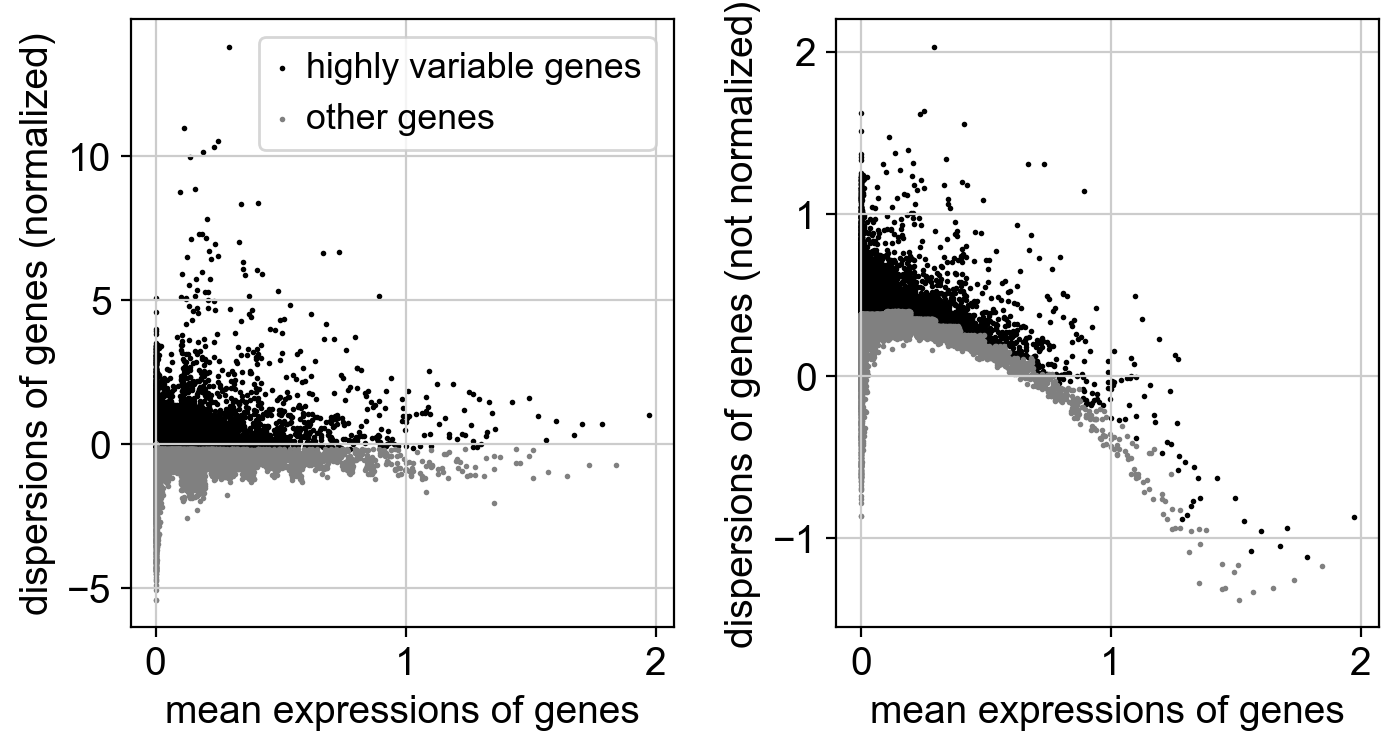

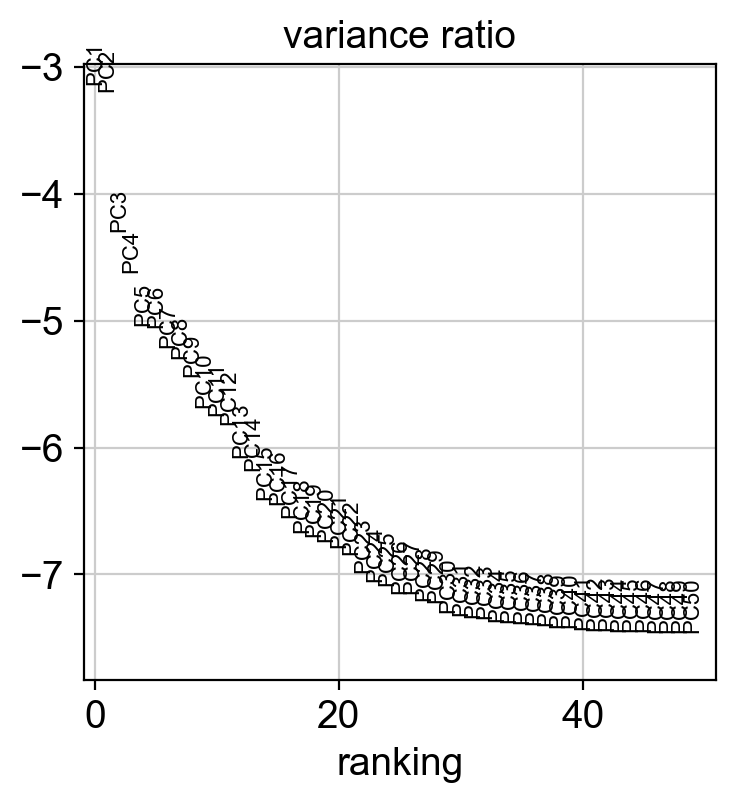

In [4]:
# Saving count data
rdata.layers["counts"] = rdata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(rdata)
# Logarithmize the data
sc.pp.log1p(rdata)
sc.pp.highly_variable_genes(rdata, n_top_genes=10000, batch_key="sample")
sc.pl.highly_variable_genes(rdata)
sc.tl.pca(rdata)
sc.pl.pca_variance_ratio(rdata, n_pcs=50, log=True)
sc.pp.neighbors(rdata)
sc.tl.umap(rdata)


In [5]:

umap = pd.read_csv(ROOT_DIR2+"/Greenleaf_HM_3file/3file/umap_reduction.tsv.gz", header=0, sep='\t', index_col=0)
rdata.obsm['X_umap2'] = rdata.obsm['X_umap']
rdata.obsm['X_umap']  = umap.to_numpy()

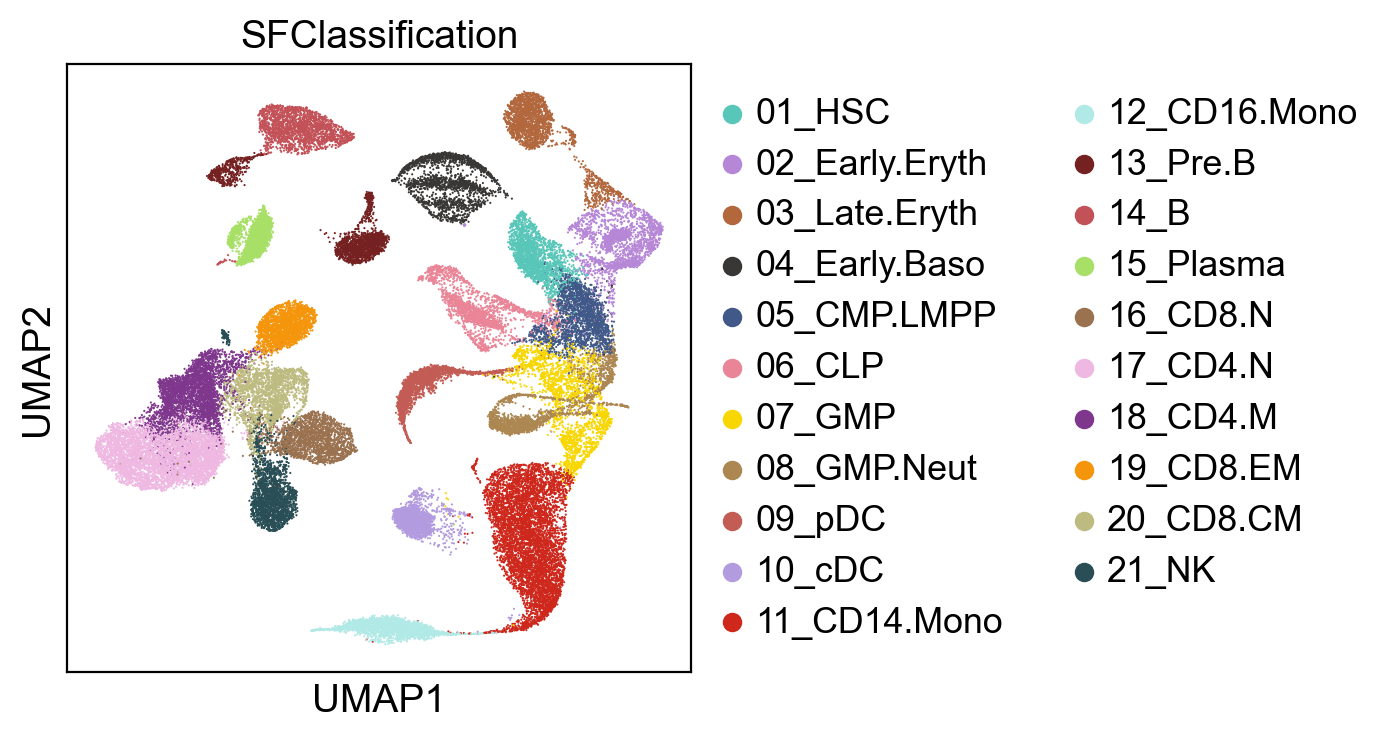

In [6]:
cols = []
with open(ROOT_DIR2+"/Greenleaf_HM_3file/3file/cols.tsv") as f:
    cols = [line.rstrip('\n') for line in f]
sc.pl.umap(rdata, color = "SFClassification", palette = cols)

## LOAD 3 FILE QUERY

In [7]:
samples = {
    "query": ROOT_DIR1+"/3file",
}
adatas = {}

for sample_id, filename in samples.items():
    sample_adata = sc.read_10x_mtx(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
meta = pd.read_csv(ROOT_DIR1+"/3file/meta.csv", header=0, sep=',', index_col=0)
meta = meta.loc[adata.obs.index]
adata.obs = pd.concat([meta, adata.obs], axis=1)

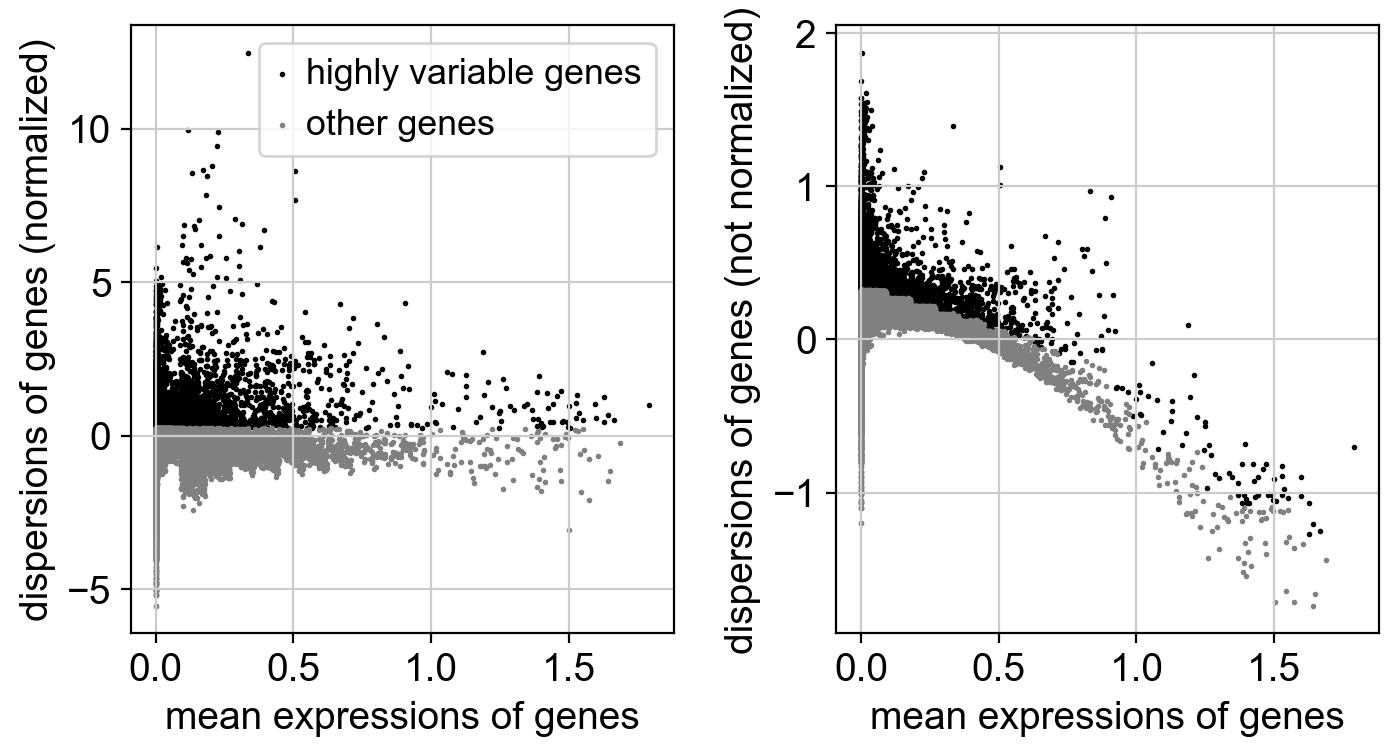

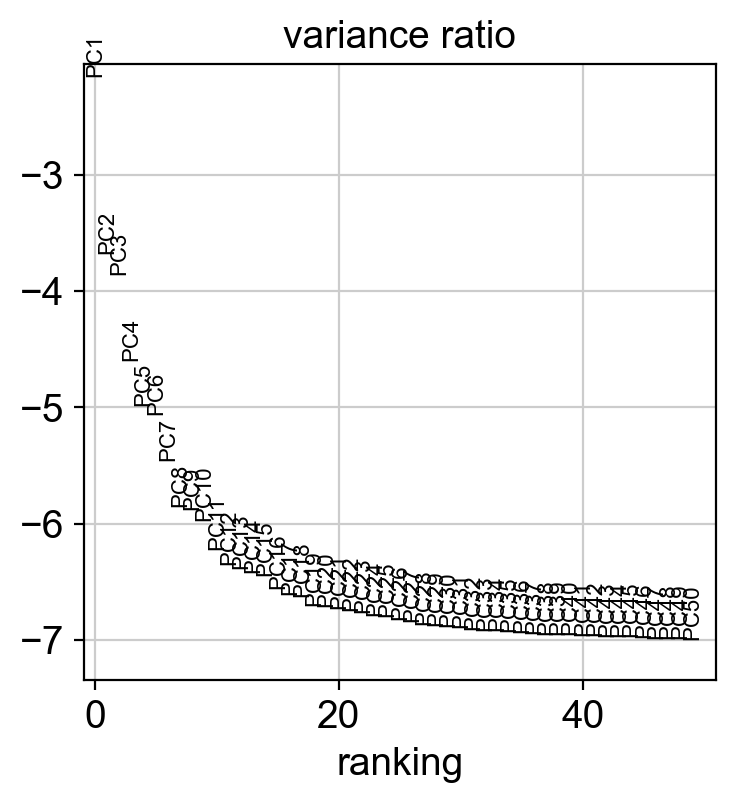

In [8]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=10000, batch_key="sample")
sc.pl.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

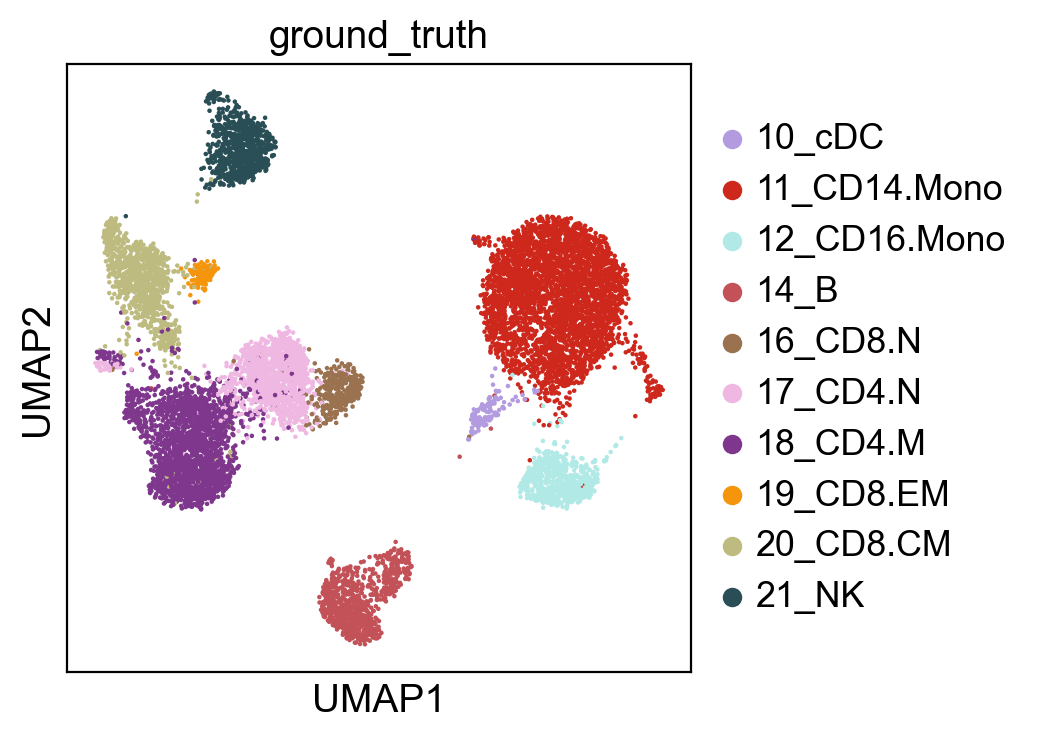

In [9]:

cols2 = dict(map(lambda i,j : (i,j) , sorted(rdata.obs["SFClassification"].unique()), cols))
sc.pl.umap(adata, color = "ground_truth", palette = cols2)

In [10]:
umap = pd.read_csv(ROOT_DIR1+"/3file/umap_reduction.tsv.gz", header=0, sep='\t', index_col=0)
adata.obsm['X_umap2'] = adata.obsm['X_umap']
adata.obsm['X_umap']  = umap.to_numpy()

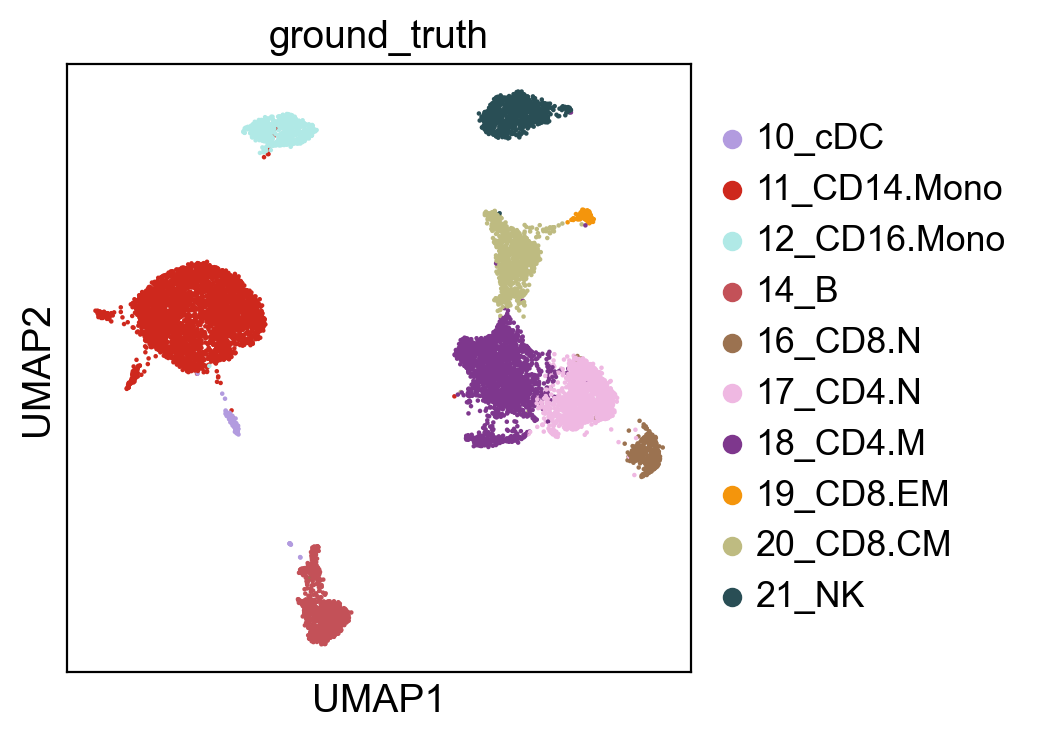

In [11]:
sc.pl.umap(adata, color = "ground_truth", palette = cols2)

## find variable genes

In [12]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
sc.pp.highly_variable_genes(adata,  n_top_genes=10000)
sc.pp.highly_variable_genes(adata,  n_top_genes=10000)
vg = intersection(adata.var.index[adata.var['highly_variable'].to_numpy()].tolist(), rdata.var.index[rdata.var['highly_variable'].to_numpy()].tolist())

In [13]:
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_mlr", FUNC= "mlr", selected_genes=vg)
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_nb", FUNC= "nb", selected_genes=vg)
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_nn", FUNC= "nn", selected_genes=vg)

Preparing data...
Subsetting to selected genes.
Normalizing data...
Predictions added to query_cds.obs['vmP_mlr']
Preparing data...
Subsetting to selected genes.
Normalizing data...
Predictions added to query_cds.obs['vmP_nb']
Preparing data...
Subsetting to selected genes.
Normalizing data...
Iteration 1, loss = 0.28485721
Iteration 2, loss = 0.04725963
Iteration 3, loss = 0.01730916
Iteration 4, loss = 0.00455322
Iteration 5, loss = 0.00123200
Iteration 6, loss = 0.00076469
Iteration 7, loss = 0.00062136
Iteration 8, loss = 0.00055678
Iteration 9, loss = 0.00051646
Iteration 10, loss = 0.00048707
Iteration 11, loss = 0.00046460
Iteration 12, loss = 0.00044733
Iteration 13, loss = 0.00043291
Iteration 14, loss = 0.00042085
Iteration 15, loss = 0.00041058
Iteration 16, loss = 0.00040148
Iteration 17, loss = 0.00039319
Iteration 18, loss = 0.00038571
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Predictions added to query_cds.obs['vmP_nn']


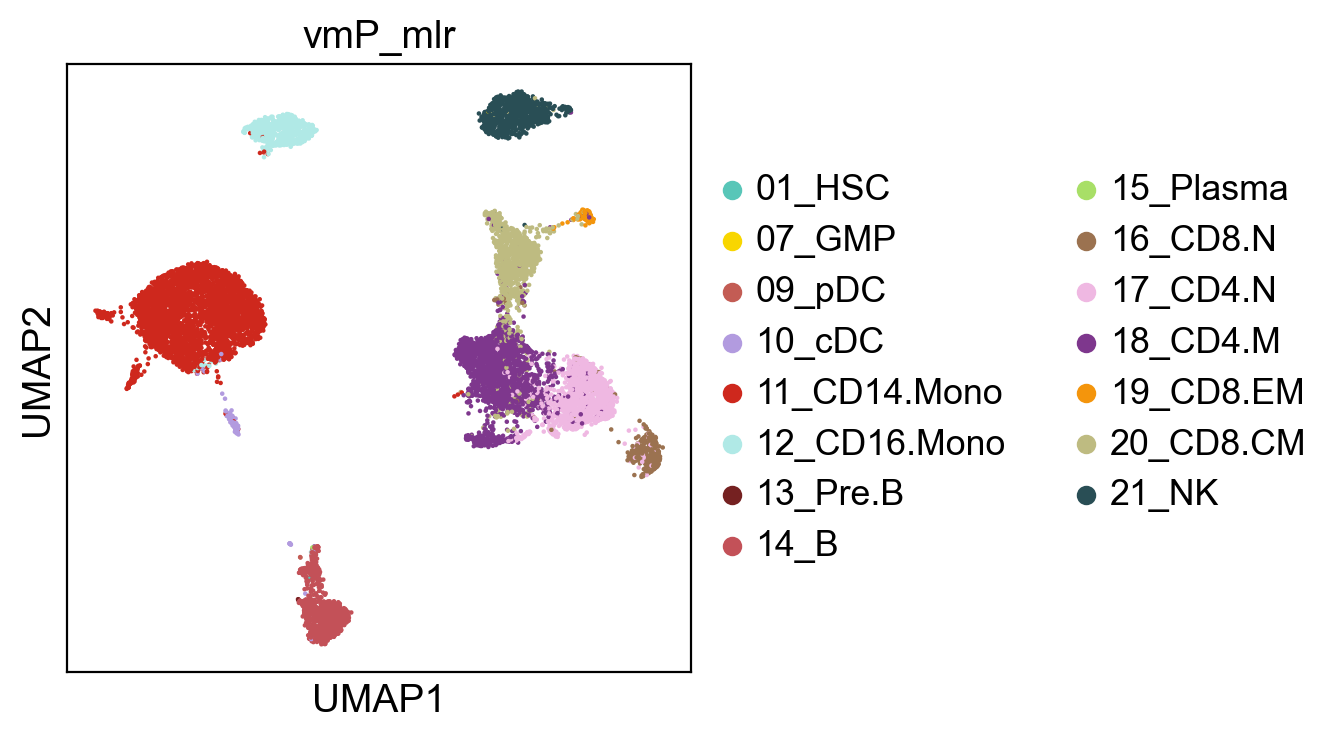

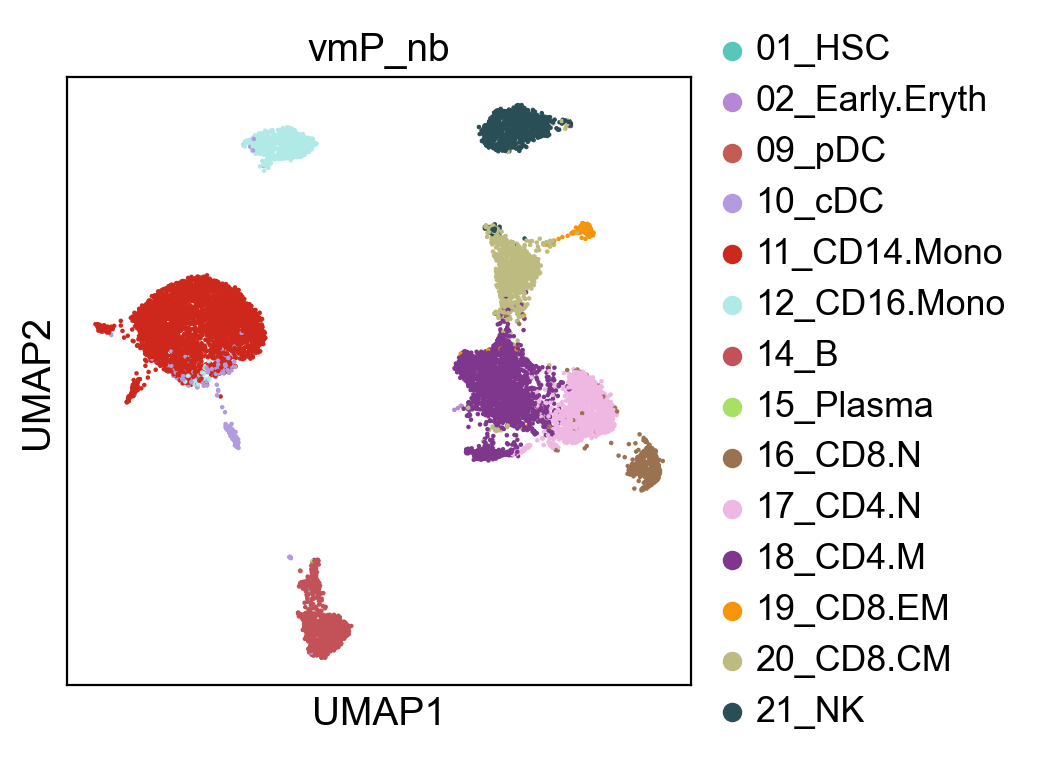

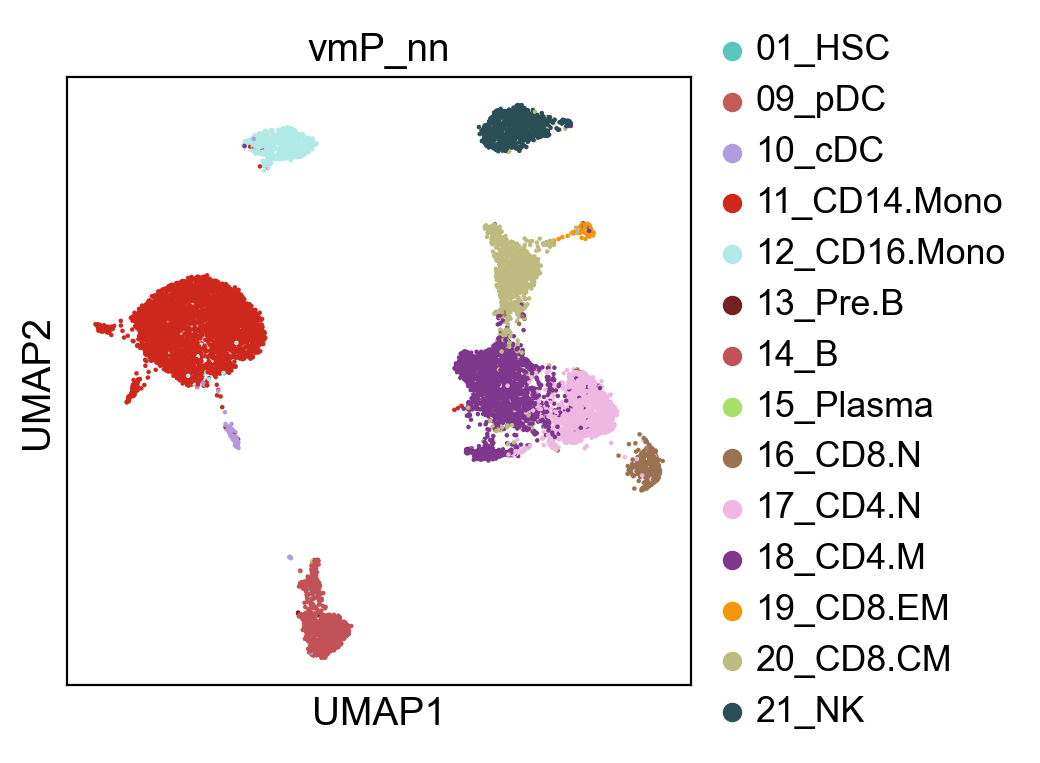

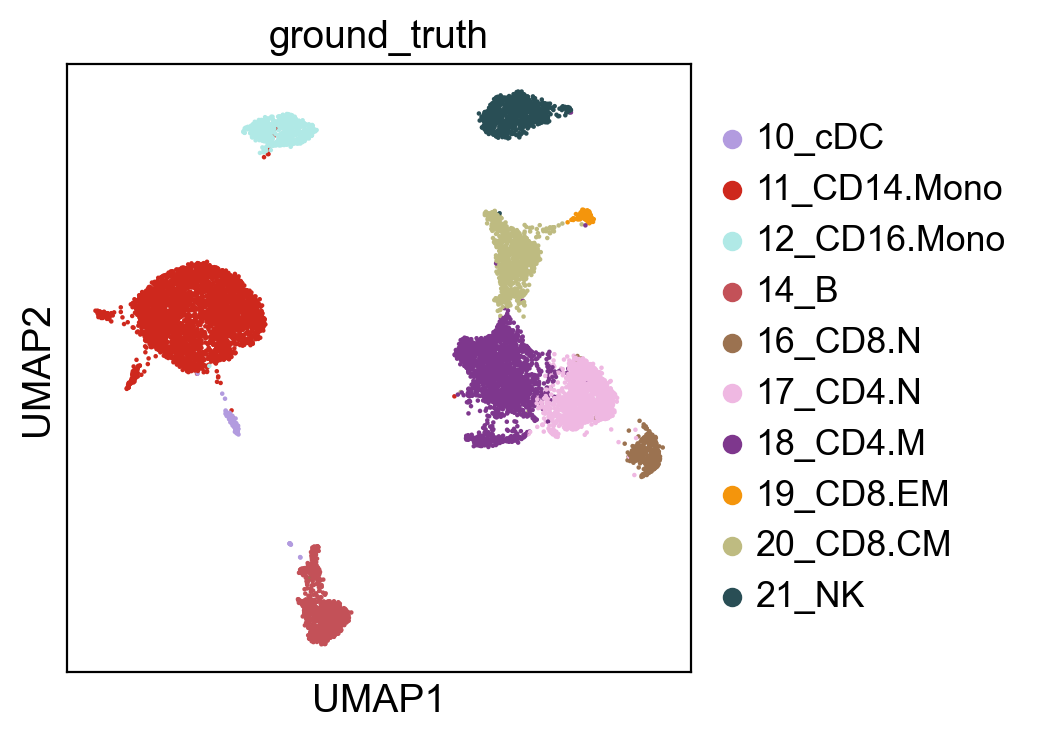

In [12]:
sc.pl.umap(adata, color = "vmP_mlr", palette = cols2)
sc.pl.umap(adata, color = "vmP_nb", palette = cols2)
sc.pl.umap(adata, color = "vmP_nn", palette = cols2)
sc.pl.umap(adata, color = "ground_truth", palette = cols2)